# Evaluation & Vizualization

## Evaluation Metrics/Properties:

- **Coverage**
- **Confidence**
- **Similarity**
- **Diversity**
- **Speed**
- **Memory Usage**  <br><br>
- Trust
- Novelty
- Serendipity
- Utility
- Risk
- Robustness
- Privacy
- Adaptability
- Scalability
- Prediction Accuracy
    - Ratings Prediction Accuracy (ratings / feedback)
    - Usage Prediction (feedback)
    - Ranking Measures

**Prediction Accuracy - needs different Dataset that has User feedback to know what the ground truth is for books**
Ranking Measures - Precision@K, Recall@K, NDCG@K
- how well the algorithm ranks relevant books in the top K recommendations

- need to have GROUND TRUTH

## How metrics will be calculated
- Similarity -> avg Cosine Similarity
  - similarity_score.mean()

- Diversity -> variance of the Cosine Similarity Scores
  - np.var(similarity_score)

- Confidence -> standard deviation of Cosine Similarity Scores
  - similarity_score.std()
  - 1 / (1 + similarity_std) (inverted confidence)

- Coverage -> Number of unique recommendations / Total items in the dataset
  - round((len(recommendations['book_index'].unique()) / total_items)*100, 2)


## Ratings / Reviews / Genres -> in the GoodReads Dataset  
- Add metadata to the recommended results for each algorithm to see which algo recommended books with more:
  - ratings
  - reviews
  - higher ratings
  - matching genres


In [2]:
import os
import pandas as pd
import re

# === Load and clean metadata ===
metadata = pd.read_csv("../datasets/book_details_clean.csv", encoding='ISO-8859-1')

# Clean numeric fields (remove commas, non-breaking spaces, etc.)
metadata['no_of_ratings'] = (
    metadata['no_of_ratings']
    .astype(str)
    .str.replace(r'[^\d]', '', regex=True)
    .astype(int)
)
metadata['no_of_reviews'] = (
    metadata['no_of_reviews']
    .astype(str)
    .str.replace(r'[^\d]', '', regex=True)
    .astype(int)
)

# === Setup paths and config ===
base_directory_results = "results/results_for_description/results"
algos = ["bert", "bow", "fasttext", "glove", "lsa", "tf_idf"]

# Columns to preserve and enrich
keep_original = ['book_index', 'similarity_score']
enrich_cols = ['title', 'author', 'rating', 'no_of_ratings', 'no_of_reviews', 'genres']
ordered_cols = ['book_index', 'similarity_score'] + enrich_cols

# === Main loop ===
for algo in algos:
    algo_path = os.path.join(base_directory_results, algo)
    output_path = os.path.join(algo_path, "results_metadata")
    os.makedirs(output_path, exist_ok=True)

    for file in os.listdir(algo_path):
        if file.endswith(".csv"):
            match = re.search(r'_(\d+)\.csv$', file)
            if not match:
                continue

            run_path = os.path.join(algo_path, file)
            run_df = pd.read_csv(run_path)

            # Select only needed columns and ensure book_index is int
            clean_df = run_df[keep_original].copy()
            clean_df['book_index'] = clean_df['book_index'].astype(int)

            # Enrich rows using metadata
            def enrich_row(row):
                try:
                    index = int(row['book_index'])
                    if 0 <= index < len(metadata):
                        book = metadata.iloc[index]
                        for col in enrich_cols:
                            row[col] = book[col]
                    else:
                        print(f"⚠️ Skipped out-of-range index {index} in file {file}")
                except Exception as e:
                    print(f"❌ Error enriching row in file {file}: {e}")
                return row

            enriched_df = clean_df.apply(enrich_row, axis=1)

            # Enforce consistent column order
            enriched_df = enriched_df[ordered_cols]

            # Save output
            output_file = os.path.join(output_path, file)
            enriched_df.to_csv(output_file, index=False)
            print(f"✅ Saved: {output_file}")


⚠️ Skipped out-of-range index 13278 in file bert_multi_performance_results_70.csv
⚠️ Skipped out-of-range index 13292 in file bert_multi_performance_results_70.csv
⚠️ Skipped out-of-range index 13298 in file bert_multi_performance_results_70.csv
⚠️ Skipped out-of-range index 13299 in file bert_multi_performance_results_70.csv
⚠️ Skipped out-of-range index 13318 in file bert_multi_performance_results_70.csv
⚠️ Skipped out-of-range index 13280 in file bert_multi_performance_results_70.csv
⚠️ Skipped out-of-range index 13308 in file bert_multi_performance_results_70.csv
⚠️ Skipped out-of-range index 13293 in file bert_multi_performance_results_70.csv
⚠️ Skipped out-of-range index 13316 in file bert_multi_performance_results_70.csv
✅ Saved: results/results_for_description/results\bert\results_metadata\bert_multi_performance_results_70.csv
⚠️ Skipped out-of-range index 13322 in file bert_multi_performance_results_71.csv
⚠️ Skipped out-of-range index 13279 in file bert_multi_performance_resu

In [ ]:
import os
import pandas as pd
import numpy as np
import re

# === Load and clean full metadata ===
metadata = pd.read_csv("../datasets/book_details_clean.csv", encoding='ISO-8859-1')
metadata['no_of_ratings'] = (
    metadata['no_of_ratings']
    .astype(str)
    .str.replace(r'[^\d]', '', regex=True)
    .astype(int)
)
metadata['no_of_reviews'] = (
    metadata['no_of_reviews']
    .astype(str)
    .str.replace(r'[^\d]', '', regex=True)
    .astype(int)
)

# Global averages for weighted rating
C = metadata['rating'].mean()
m = metadata['no_of_ratings'].median()

def weighted_rating(R, v, m, C):
    return (v / (v + m)) * R + (m / (v + m)) * C

# === Directories and Config ===
base_path = "results/results_for_description/results"
algos = ["bert", "bow", "fasttext", "glove", "lsa", "tf_idf"]

# === Storage for all results ===
all_algo_metrics = []

# === Main loop ===
for algo in algos:
    algo_metrics = {
        "algorithm": algo,
        "avg_rating": [],
        "avg_no_of_ratings": [],
        "avg_no_of_reviews": [],
        "avg_weighted_rating": [],
        "avg_genre_alignment": []
    }

    metadata_dir = os.path.join(base_path, algo, "results_metadata")

    for filename in os.listdir(metadata_dir):
        if not filename.endswith(".csv"):
            continue

        input_index_match = re.search(r'_(\d+)\.csv$', filename)
        if not input_index_match:
            continue

        input_index = int(input_index_match.group(1))
        input_genres_raw = metadata.loc[input_index, 'genres']
        input_genres = set(map(str.strip, str(input_genres_raw).split(',')))

        file_path = os.path.join(metadata_dir, filename)
        df = pd.read_csv(file_path)
        df = df.dropna(subset=['genres'])

        # Parse genres into sets
        df['genres'] = df['genres'].apply(lambda x: set(map(str.strip, str(x).split(','))))

        # Genre overlap
        genre_scores = df['genres'].apply(
            lambda g: len(input_genres & g) / len(input_genres) if len(input_genres) > 0 else 0
        )

        # Weighted ratings
        weighted_scores = [
            weighted_rating(r, v, m, C)
            for r, v in zip(df['rating'], df['no_of_ratings'])
        ]

        # Append run metrics
        algo_metrics["avg_rating"].append(df['rating'].mean())
        algo_metrics["avg_no_of_ratings"].append(df['no_of_ratings'].mean())
        algo_metrics["avg_no_of_reviews"].append(df['no_of_reviews'].mean())
        algo_metrics["avg_weighted_rating"].append(np.mean(weighted_scores))
        algo_metrics["avg_genre_alignment"].append(np.mean(genre_scores))

    # Compute average over all 10 runs
    all_algo_metrics.append({
        "algorithm": algo,
        "avg_rating": np.mean(algo_metrics["avg_rating"]),
        "avg_no_of_ratings": np.mean(algo_metrics["avg_no_of_ratings"]),
        "avg_no_of_reviews": np.mean(algo_metrics["avg_no_of_reviews"]),
        "avg_weighted_rating": np.mean(algo_metrics["avg_weighted_rating"]),
        "genre_alignment (%)": round(np.mean(algo_metrics["avg_genre_alignment"]) * 100, 1)
    })

# Create final results DataFrame
results_df = pd.DataFrame(all_algo_metrics)

# Round values nicely
results_df = results_df.round({
    "avg_rating": 3,
    "avg_weighted_rating": 3,
    "avg_no_of_ratings": 0,
    "avg_no_of_reviews": 0
})

# Save cleaned version
output_path = os.path.join(base_path, "algo_recommendation_quality_metrics_cleaned.csv")
results_df.to_csv(output_path, index=False)
print(f"✅ Cleaned metrics saved to {output_path}")
results_df.head(10)


✅ Cleaned metrics saved to separate_algos_with_ratings/results\algo_recommendation_quality_metrics_cleaned.csv


,algorithm,avg_rating,avg_no_of_ratings,avg_no_of_reviews,avg_weighted_rating,genre_alignment (%)
0,bert,4.0160000,65661.0000000,3952.0000000,4.0330000,14.4000000
1,bow,4.0610000,72304.0000000,3910.0000000,4.0520000,21.5000000
2,fasttext,4.0120000,68134.0000000,3930.0000000,4.0290000,13.4000000
3,glove,4.0140000,68381.0000000,3912.0000000,4.0300000,13.0000000
4,lsa,4.0310000,58405.0000000,3602.0000000,4.0350000,14.9000000
5,tf_idf,4.0580000,47547.0000000,2849.0000000,4.0370000,15.6000000


### Try Radar-chart vizualization

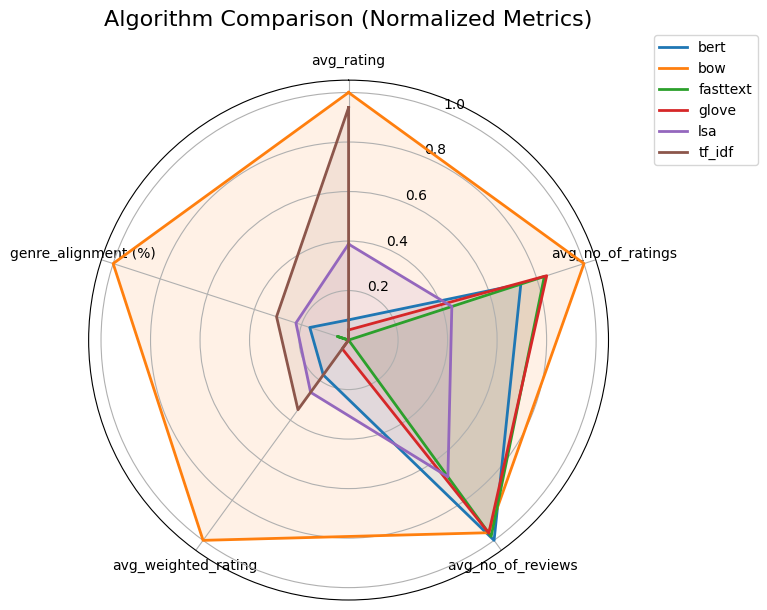

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('results/results_for_description/results/algo_recommendation_quality_metrics_cleaned.csv')

# Normalize values for radar chart
metrics = df.columns[1:]
normalized_df = df.copy()
for metric in metrics:
    min_val = df[metric].min()
    max_val = df[metric].max()
    normalized_df[metric] = (df[metric] - min_val) / (max_val - min_val)

# Radar chart setup
labels = list(metrics)
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Loop

# Create radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each algorithm
for i, row in normalized_df.iterrows():
    values = row[metrics].tolist()
    values += values[:1]  # Loop
    ax.plot(angles, values, label=row['algorithm'], linewidth=2)
    ax.fill(angles, values, alpha=0.1)

# Configure plot aesthetics
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Algorithm Comparison (Normalized Metrics)", size=16, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


### Try Heatmap visualization

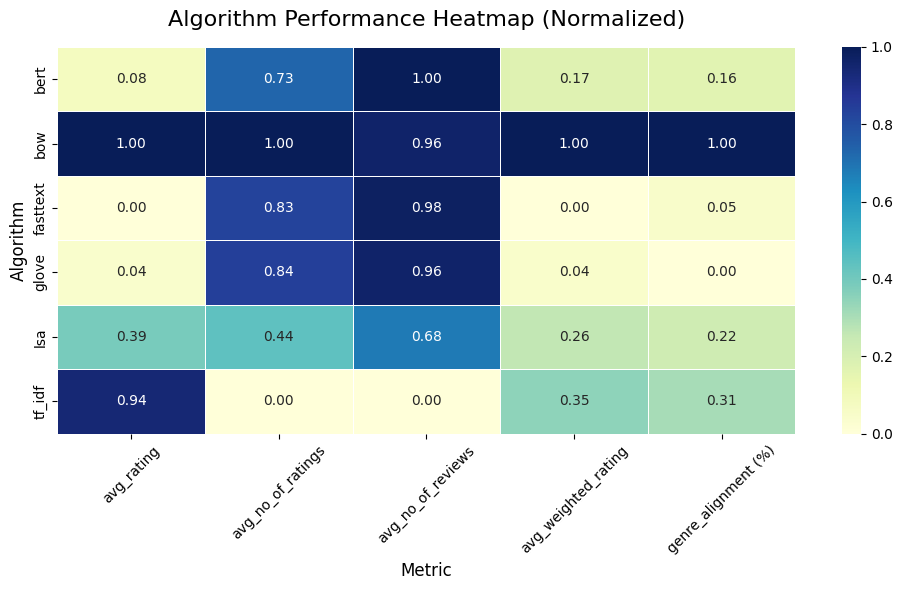

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load your cleaned metrics from CSV ===
df = pd.read_csv('results/results_for_description/results/algo_recommendation_quality_metrics_cleaned.csv')
df.set_index("algorithm", inplace=True)

# === Normalize values (0–1 scale) across each column ===
normalized_df = (df - df.min()) / (df.max() - df.min())

# === Plot the heatmap ===
plt.figure(figsize=(10, 6))
sns.heatmap(normalized_df, annot=True, cmap="YlGnBu", linewidths=0.5, fmt=".2f", annot_kws={"size": 10})

# === Style and labels ===
plt.title("Algorithm Performance Heatmap (Normalized)", fontsize=16, pad=15)
plt.ylabel("Algorithm", fontsize=12)
plt.xlabel("Metric", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# === Show it ===
plt.show()


# Calculating METRICS - Sim/Div/Conf/Cov/Time/Memory/CPU

## METRICS - averages - For 1 Algo - 10 runs  
- Sentence-Bert

In [6]:
import os
import pandas as pd
import numpy as np

# Base directory where all algorithm folders and CSVs are located
base_directory = 'results/results_for_description/results/bert'

# Total number of items in the dataset for coverage calculation
total_items = 13263.0

def calculate_metrics_for_csv(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Extract only the rows with recommendations (rows where 'book_index' is present)
    recommendations = df
    
    # Calculate average similarity score for the CSV
    avg_similarity = recommendations['similarity_score'].mean()

    # Coverage: Number of unique recommendations / Total items in the dataset
    coverage = round((len(recommendations['book_index'].unique()) / total_items)*100,2)

    # Confidence: Proportion of non-zero similarity scores
    #confidence = (recommendations['similarity_score'] > 0).mean()
    confidence = recommendations['similarity_score'].std()

    # Diversity: Variance of similarity scores
    diversity = np.var(recommendations['similarity_score'])
    
    # Return the metrics for this CSV file
    return {
        'file': os.path.basename(file_path),
        'avg_similarity': avg_similarity,
        'coverage': coverage,
        'confidence': confidence,
        'diversity': diversity
    }

# Main function to process all CSVs in the specified algorithm folder
def process_algorithm_folder(base_directory):
    all_results = []

    # Iterate through each CSV file in the folder
    for file in os.listdir(base_directory):
        if file.endswith('.csv'):
            file_path = os.path.join(base_directory, file)
            
            # Calculate metrics for the current CSV file
            metrics = calculate_metrics_for_csv(file_path)
            all_results.append(metrics)
    
    # Convert the results into a pandas DataFrame
    metrics_df = pd.DataFrame(all_results)

    return metrics_df

# Process the CSV files and calculate metrics
metrics_df = process_algorithm_folder(base_directory)

# Print the metrics table
metrics_df.head(10)


,file,avg_similarity,coverage,confidence,diversity
0,bert_multi_performance_results_70.csv,0.331203,10.37,0.040166,0.001612
1,bert_multi_performance_results_71.csv,0.390281,18.07,0.044847,0.002010
2,bert_multi_performance_results_72.csv,0.303792,0.90,0.054643,0.002961
3,bert_multi_performance_results_73.csv,0.385762,1.68,0.063421,0.004004
4,bert_multi_performance_results_74.csv,0.370332,2.84,0.044713,0.001994
5,bert_multi_performance_results_75.csv,0.342118,17.09,0.044174,0.001950
6,bert_multi_performance_results_76.csv,0.275503,23.35,0.034888,0.001217
7,bert_multi_performance_results_77.csv,0.352024,16.15,0.042513,0.001807
8,bert_multi_performance_results_78.csv,0.286973,2.24,0.040169,0.001608
9,bert_multi_performance_results_79.csv,0.455433,0.23,0.074909,0.005424


## METRICS - averages - For all 6 Algos

In [ ]:
import os
import pandas as pd
import numpy as np

pd.options.display.float_format = '{:.7f}'.format

def calculate_metrics_for_csv(file_path, total_items):
    if "summary" in file_path:
        return


    # Read the CSV file
    df = pd.read_csv(file_path)

    # Extract only the rows with recommendations (rows where 'book_index' is present)
    recommendations = df
    
    # Calculate average similarity score for the CSV
    avg_similarity = recommendations['similarity_score'].mean()

    # Coverage: Number of unique recommendations / Total items in the dataset
    coverage = round((len(recommendations['book_index'].unique()) / total_items)*100, 2)

    # Confidence: Standard deviation of similarity scores for this run
    similarity_std = recommendations['similarity_score'].std()
    confidence = 1 / (1 + similarity_std)  # Inverted confidence

    # Diversity: Variance of similarity scores
    diversity = np.var(recommendations['similarity_score'])
    
    # Return the metrics for this CSV file
    return {
        'file': os.path.basename(file_path),
        'avg_similarity': avg_similarity,
        'coverage': coverage,
        'confidence': confidence,
        'diversity': diversity
    }

def process_algorithm_folder(base_directory, total_items):
    all_results = []

    # Iterate through each CSV file in the folder
    for file in os.listdir(base_directory):
        if file.endswith('.csv'):
            file_path = os.path.join(base_directory, file)
            
            # Calculate metrics for the current CSV file
            metrics = calculate_metrics_for_csv(file_path, total_items)
            if metrics: 
                all_results.append(metrics)
    
    # Convert the results into a pandas DataFrame
    metrics_df = pd.DataFrame(all_results)

    # Calculate the average metrics for the algorithm (average across all runs)
    avg_metrics = {
        'Algorithm': os.path.basename(base_directory),
        'avg_similarity': round(metrics_df['avg_similarity'].mean(),3),
        'coverage': round(metrics_df['coverage'].mean(),2),
        'confidence': round(metrics_df['confidence'].mean(),5),
        'diversity': metrics_df['diversity'].mean()
    }

    # Save the metrics of individual runs for the algorithm
    metrics_df.to_csv(f'{base_directory}_metrics_per_run.csv', index=False)

    return avg_metrics, metrics_df

def process_all_algorithms(base_directory_root, total_items):
    all_algorithms_metrics = []
    for algo_folder in os.listdir(base_directory_root):
        algo_folder_path = os.path.join(base_directory_root, algo_folder)
        
        if os.path.isdir(algo_folder_path):
            # Process each algorithm folder and get its average metrics
            avg_metrics, run_metrics_df = process_algorithm_folder(algo_folder_path, total_items)
            
            avg_metrics['diversity'] = avg_metrics['diversity'].round(7) 
            all_algorithms_metrics.append(avg_metrics)
    
    # Create a DataFrame from the average metrics of all algorithms
    final_metrics_df = pd.DataFrame(all_algorithms_metrics)
    
    # Save the final summary DataFrame for all algorithms
    final_metrics_df.to_csv(f'{base_directory_root}/average_metrics.csv', index=False)
    
    return final_metrics_df

# Define the base directory containing the algorithm folders (e.g., 'bert', 'bow', 'fasttext', etc.)
base_directory_root_description = 'results/results_for_description/results'
base_directory_root_paragraph = 'results/results_for_paragraph_quarter/results'


# Total number of items in the dataset for coverage calculation
total_items_description = 13263
total_items_paragraph = 45461

# Process all algorithms and save the final summary
average_metrics_df_decsription = process_all_algorithms(base_directory_root_description, total_items_description)
average_metrics_df_paragraph = process_all_algorithms(base_directory_root_paragraph, total_items_paragraph)


# Print the final summary DataFrame for all algorithms
average_metrics_df_paragraph.head(10)
average_metrics_df_decsription.head(10)


,Algorithm,avg_similarity,coverage,confidence,diversity
0,bert,0.3490000,9.2900000,0.9539100,0.0024588
1,bow,0.1930000,1.3000000,0.9725200,0.0007391
2,fasttext,0.9390000,15.3200000,0.9903200,0.0000958
3,glove,0.9890000,21.5200000,0.9979900,0.0000041
4,lsa,0.2970000,1.2000000,0.9516400,0.0027325
5,tf_idf,0.1960000,0.3400000,0.9621800,0.0016912


## TIMES + IPS

In [ ]:
import os
import pandas as pd

def calculate_avg_metrics_for_algorithm(file_path):
    if "average_times" in file_path:
        return

    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Calculate the average elapsed time and average iterations per second
    avg_elapsed_time = df['elapsed_time'].mean()
    avg_ips = df['iterations_per_second'].mean()

    # Return the metrics for this algorithm
    return {
        'Algorithm': os.path.basename(file_path).replace('_multi_performance_summary.csv', ''),
        'avg_elapsed_time': round(avg_elapsed_time,3),
        'avg_ips': round(avg_ips,3)
    }

def process_all_algorithm_times(base_directory_root):
    all_algorithms_metrics = []
    
    # Iterate through each time result CSV file in the folder
    for file in os.listdir(base_directory_root):
        if file.endswith('.csv'):
            file_path = os.path.join(base_directory_root, file)
            
            # Calculate metrics for the current algorithm
            avg_metrics = calculate_avg_metrics_for_algorithm(file_path)
            all_algorithms_metrics.append(avg_metrics)
    
    # Create a DataFrame from the average metrics of all algorithms
    final_metrics_df = pd.DataFrame(all_algorithms_metrics)
    
    # Save the final summary DataFrame for all algorithms
    final_metrics_df.to_csv(f'{base_directory_root}/average_times_paragraphs.csv', index=False)
    
    return final_metrics_df



# Define the base directory containing the algorithm time result files
base_directory_root_description = 'results/results_for_description/times_descriptions'
base_directory_root_paragraph = 'results/results_for_paragraph_quarter/times_paragraphs'

# Process all algorithms and save the final summary
average_times_decription = process_all_algorithm_times(base_directory_root_description)
average_times_paragraph = process_all_algorithm_times(base_directory_root_paragraph)

# Print the final summary DataFrame for all algorithms
average_times_paragraph.head(10)


,Algorithm,avg_elapsed_time,avg_ips
0,bert,74.4560000,1655.9140000
1,bow,15.2560000,2990.3930000
2,fasttext,49.9590000,932.3330000
3,glove,14.8880000,3061.4400000
4,lsa,13.2480000,3420.5360000
5,tf_idf,15.2060000,2974.6770000


## MEMORY

In [ ]:
import os
import pandas as pd



def calculate_avg_memory_usage_for_algorithm(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Calculate the average memory usage for the algorithm (across all timestamps)
    avg_memory_usage = df['memory_usage'].mean()

    # Return the metrics for this algorithm
    return {
        'Algorithm': os.path.basename(file_path),
        'avg_memory_usage': avg_memory_usage
    }

def process_all_algorithm_memory_usage(base_directory_root):
    all_algorithms_metrics = []
    
    # Iterate through each memory usage result CSV file in the folder
    for algo_folder in os.listdir(base_directory_root):
        algo_folder_path = os.path.join(base_directory_root, algo_folder)
        
        if os.path.isdir(algo_folder_path):
            total_memory_usage = 0
            num_runs = 0
            
            # Process each CSV file in the algorithm folder (representing individual runs)
            for file in os.listdir(algo_folder_path):
                if file.endswith('.csv'):
                    file_path = os.path.join(algo_folder_path, file)
                    
                    # Calculate metrics for the current algorithm run
                    avg_metrics = calculate_avg_memory_usage_for_algorithm(file_path)
                    total_memory_usage += avg_metrics['avg_memory_usage']
                    num_runs += 1
            
            # Calculate the average memory usage across all runs for this algorithm
            avg_memory_usage = total_memory_usage / num_runs if num_runs > 0 else 0
            
            # Save the average memory usage for the algorithm
            all_algorithms_metrics.append({
                'Algorithm': algo_folder,
                'avg_memory_usage': round(avg_memory_usage, 2)
            })
    
    # Create a DataFrame from the average metrics of all algorithms
    final_metrics_df = pd.DataFrame(all_algorithms_metrics)
    
    # Save the final summary DataFrame for all algorithms
    final_metrics_df.to_csv(f'{base_directory_root}/memory_usage_summary.csv', index=False)
    
    return final_metrics_df


# Define the base directory containing the algorithm time result files
base_directory_root_description = 'results/results_for_description/memory_tracking'
base_directory_root_paragraph = 'results/results_for_paragraph_quarter/memory_tracking'

# Process all algorithms and save the final summary
memory_df_description = process_all_algorithm_memory_usage(base_directory_root_description)
memory_df_paragraph = process_all_algorithm_memory_usage(base_directory_root_paragraph)


memory_df_description.head(10)


,Algorithm,avg_memory_usage
0,bert,1141.3800000
1,bow,202.8900000
2,fasttext,1193.4300000
3,glove,344.3300000
4,lsa,424.8500000
5,tf_idf,193.6400000


## CPU

In [ ]:
import os
import pandas as pd


def cpu_time_for_algorithm(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Calculate the average total CPU time for the algorithm (across all runs)
    avg_cpu_time = df['total_cpu_time'].mean()

    # Return the metrics for this algorithm 
    return {
        'Algorithm': os.path.basename(file_path),
        'avg_cpu_time': avg_cpu_time
    }

def process_all_algorithm_cpu_time(base_directory_root):
    all_algorithms_metrics = []
    
    # Iterate through each CPU time result CSV file in the folder
    for algo_folder in os.listdir(base_directory_root):
        algo_folder_path = os.path.join(base_directory_root, algo_folder)
        
        if os.path.isdir(algo_folder_path):
            total_cpu_time = 0
            num_runs = 0
            
            # Process each CSV file in the algorithm folder (representing individual runs)
            for file in os.listdir(algo_folder_path):
                if file.endswith('.csv'):
                    file_path = os.path.join(algo_folder_path, file)
                    
                    # Calculate metrics for the current algorithm run
                    avg_metrics = cpu_time_for_algorithm(file_path)
                    total_cpu_time += avg_metrics['avg_cpu_time']
                    num_runs += 1
            
            # Calculate the average CPU time across all runs for this algorithm
            avg_cpu_time = total_cpu_time / num_runs if num_runs > 0 else 0
            avg_cpu_time = avg_cpu_time.round(3)

            # Save the average CPU time for the algorithm
            all_algorithms_metrics.append({
                'Algorithm': algo_folder,
                'avg_cpu_time': avg_cpu_time
            })
    
    # Create a DataFrame from the average metrics of all algorithms
    final_metrics_df = pd.DataFrame(all_algorithms_metrics)
    
    # Save the final summary DataFrame for all algorithms
    final_metrics_df.to_csv(f'{base_directory_root}/cpu_time_summary.csv', index=False)
    
    return final_metrics_df

# Define the base directory containing the algorithm CPU time result files
base_directory_root_description = 'results/results_for_description/cpu_tracking'
base_directory_root_paragraph = 'results/results_for_paragraph_quarter/cpu_tracking'

# Process all algorithms and save the final summary
cpu_avg_description = process_all_algorithm_cpu_time(base_directory_root_description)
cpu_avg_paragraph = process_all_algorithm_cpu_time(base_directory_root_paragraph)

cpu_avg_description.head(10)


,Algorithm,avg_cpu_time
0,bert,27.7570000
1,bow,0.2750000
2,fasttext,11.8210000
3,glove,3.2100000
4,lsa,2.0410000
5,tf_idf,1.7290000


## Merged Results - metrics/time/memory/cpu

In [ ]:
import pandas as pd

# Assuming these DataFrames are already created
# average_metrics_df, average_times, memory_df, cpu_avg

# Merge all DataFrames on the "Algorithm" column
description_final = pd.merge(average_metrics_df_decsription, average_times_decription, on='Algorithm', how='outer')
description_final = pd.merge(description_final, memory_df_description, on='Algorithm', how='outer')
description_final = pd.merge(description_final, cpu_avg_description, on='Algorithm', how='outer')

# Save the final combined DataFrame to a CSV file
description_final.to_csv('results/results_for_description/results/final_combined_algorithm_description.csv', index=False)


paragraph_final = pd.merge(average_metrics_df_paragraph, average_times_paragraph, on='Algorithm', how='outer')
paragraph_final = pd.merge(paragraph_final, memory_df_paragraph, on='Algorithm', how='outer')
paragraph_final = pd.merge(paragraph_final, cpu_avg_paragraph, on='Algorithm', how='outer')

# Save the final combined DataFrame to a CSV file
paragraph_final.to_csv('results/results_for_paragraph_quarter/results/final_combined_algorithm_paragraph.csv', index=False)


### RESULTS FOR DESCRIPTIONS - ratings

In [ ]:
import pandas as pd 
descriptionsDF = pd.read_csv('results/results_for_description/results/final_combined_algorithm_description.csv')
descriptionsDF.head(10)

,Algorithm,avg_similarity,coverage,confidence,diversity,avg_elapsed_time,avg_ips,avg_memory_usage,avg_cpu_time
0,bert,0.3490000,9.2900000,0.9539100,0.0024588,21.2170000,1643.4560000,1141.3800000,27.7570000
1,bow,0.1930000,1.3000000,0.9725200,0.0007391,3.7220000,3613.7680000,202.8900000,0.2750000
2,fasttext,0.9390000,15.3200000,0.9903200,0.0000958,13.3730000,1015.2870000,1193.4300000,11.8210000
3,glove,0.9890000,21.5200000,0.9979900,0.0000041,4.6460000,3138.4670000,344.3300000,3.2100000
4,lsa,0.2970000,1.2000000,0.9516400,0.0027325,3.5010000,3838.8270000,424.8500000,2.0410000
5,tf_idf,0.1960000,0.3400000,0.9621800,0.0016912,3.9730000,3359.9720000,193.6400000,1.7290000


### RESULTS FOR PARAGRAPHS - quarter

In [ ]:
import pandas as pd 
paragraphsDF = pd.read_csv('results/results_for_paragraph_quarter/results/final_combined_algorithm_paragraph.csv')

paragraphsDF.head(10)

,Algorithm,avg_similarity,coverage,confidence,diversity,avg_elapsed_time,avg_ips,avg_memory_usage,avg_cpu_time
0,bert,0.3590000,0.2000000,0.9477800,0.0033437,74.4560000,1655.9140000,1227.4400000,103.3990000
1,bow,0.2540000,0.2300000,0.9377200,0.0049934,15.2560000,2990.3930000,378.4500000,0.8090000
2,fasttext,0.9450000,0.5300000,0.9902300,0.0000988,49.9590000,932.3330000,2002.8000000,44.9640000
3,glove,0.9810000,0.2500000,0.9978700,0.0000045,14.8880000,3061.4400000,420.7800000,10.3140000
4,lsa,0.4250000,0.1200000,0.9332500,0.0055086,13.2480000,3420.5360000,744.6400000,8.1790000
5,tf_idf,0.2760000,0.0600000,0.9527900,0.0027029,15.2060000,2974.6770000,293.4900000,7.2300000


# Charts

## RADAR CHART - DESCRIPTION

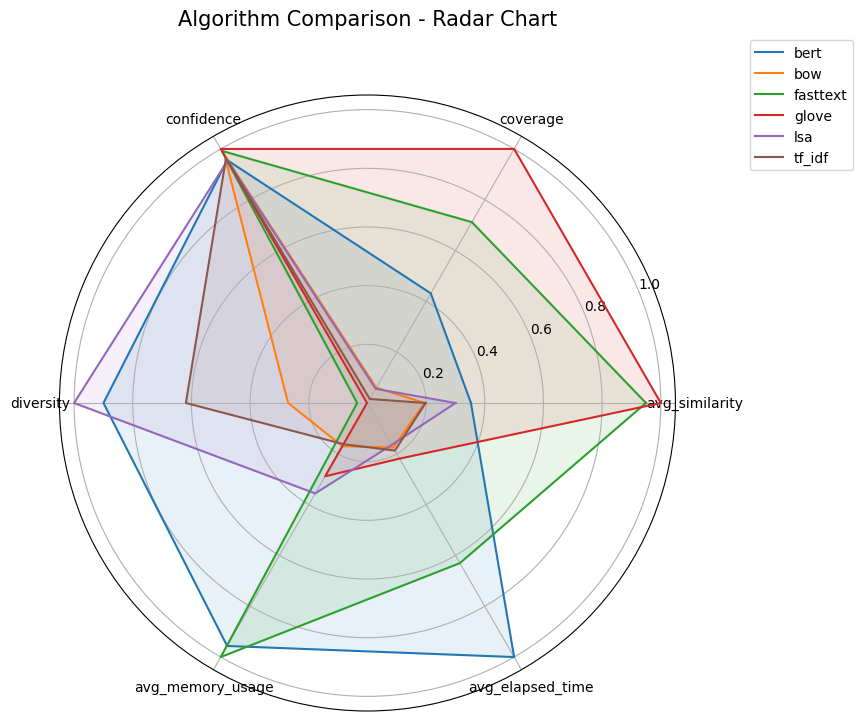

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv('results/results_for_description/results/final_combined_algorithm_description.csv')


# Normalize data for radar chart (0-1 scale)
selected_metrics = ['avg_similarity', 'coverage', 'confidence', 'diversity', 'avg_memory_usage', 'avg_elapsed_time']
df = df[['Algorithm'] + selected_metrics]
metrics = selected_metrics
df_norm = df.copy()
for metric in metrics:
    max_val = df[metric].max()
    df_norm[metric] = df[metric] / max_val  # normalize to [0, 1]

# Radar chart setup
labels = metrics
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # complete the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each algorithm
for i, row in df_norm.iterrows():
    values = row[1:].tolist()
    values += values[:1]  # repeat the first value to close the circle
    ax.plot(angles, values, label=row['Algorithm'])
    ax.fill(angles, values, alpha=0.1)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
# ax.set_yticklabels([])  # optional: hide radial labels for cleaner look
ax.set_title("Algorithm Comparison - Radar Chart", size=15, y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()


## RADAR CHART - PARAGRAPH

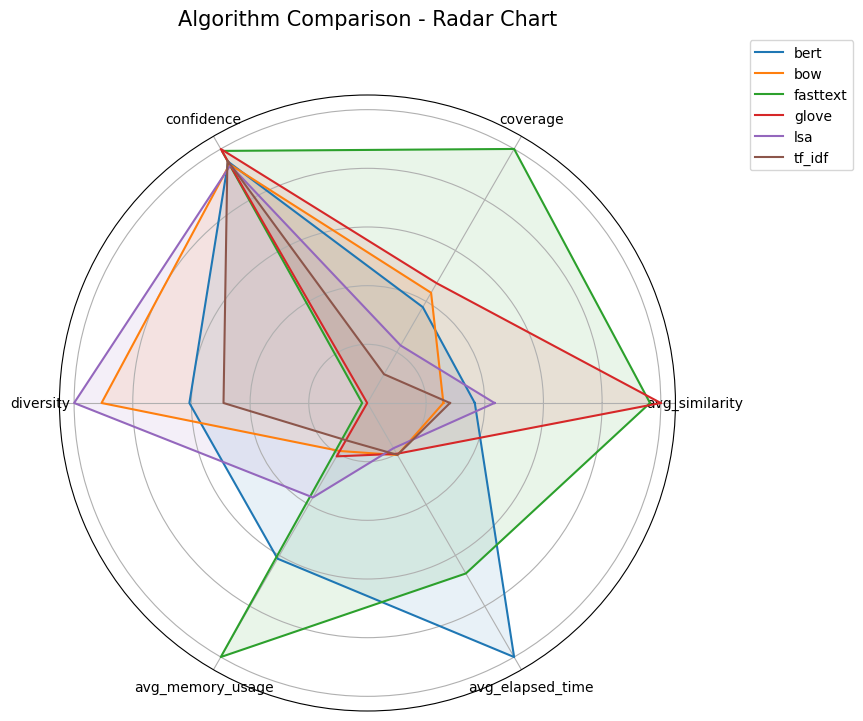

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('results/results_for_paragraph_quarter/results/final_combined_algorithm_paragraph.csv')


# Normalize data for radar chart (0-1 scale)
selected_metrics = ['avg_similarity', 'coverage', 'confidence', 'diversity', 'avg_memory_usage', 'avg_elapsed_time']
df = df[['Algorithm'] + selected_metrics]
metrics = selected_metrics
df_norm = df.copy()
for metric in metrics:
    max_val = df[metric].max()
    df_norm[metric] = df[metric] / max_val  # normalize to [0, 1]

# Radar chart setup
labels = metrics
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # complete the circle

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each algorithm
for i, row in df_norm.iterrows():
    values = row[1:].tolist()
    values += values[:1]  # repeat the first value to close the circle
    ax.plot(angles, values, label=row['Algorithm'])
    ax.fill(angles, values, alpha=0.1)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticklabels([])  # optional: hide radial labels for cleaner look
ax.set_title("Algorithm Comparison - Radar Chart", size=15, y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()


## Tried - Heatmap

C:\Users\Akos Levardy\AppData\Local\Temp\ipykernel_29572\2329986895.py:26: UserWarning: Glyph 128295 (\N{WRENCH}) missing from current font.
  plt.tight_layout()
c:\Users\Akos Levardy\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128295 (\N{WRENCH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


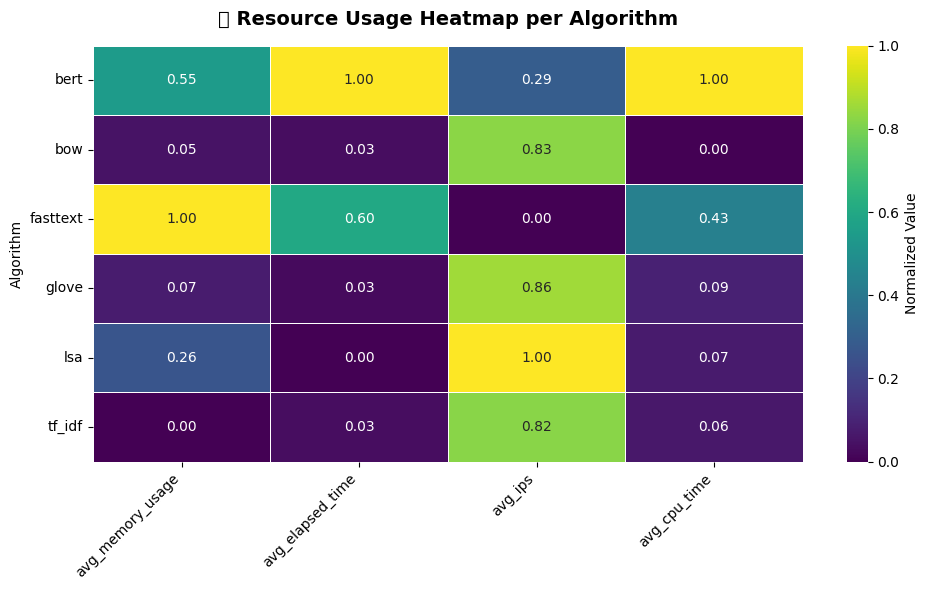

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Load your real data
df = pd.read_csv('results/result_for_description/results/final_combined_algorithm_paragraph.csv')

# Select just the resource metrics
metrics = ['avg_memory_usage', 'avg_elapsed_time', 'avg_ips', 'avg_cpu_time']
df = df[['Algorithm'] + metrics]

# Set 'Algorithm' as index so heatmap shows algorithm names on the y-axis
df.set_index('Algorithm', inplace=True)

# Normalize values for better heatmap contrast (optional but recommended)
df_normalized = (df - df.min()) / (df.max() - df.min())

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_normalized, annot=True, fmt=".2f", cmap='viridis', linewidths=0.5, cbar_kws={"label": "Normalized Value"})

# Add titles and style
plt.title('🔧 Resource Usage Heatmap per Algorithm', fontsize=14, weight='bold', pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
